In [1]:
import torch

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torchvision

In [4]:
from torch import nn
from torchvision import transforms

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

In [9]:
train_dir = 'C:\\Users\\tusha\\Downloads\\AID710\\BC2\\RSNA_Crop\\BC2'
test_dir = 'C:\\Users\\tusha\\Downloads\\AID710\\BC2\\RSNA_Crop\\test'

In [11]:
import os
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    return train_dataloader, test_dataloader, class_names

In [12]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [14]:
from torchvision import datasets

In [15]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x199e85fcdf0>,
 ['cancer', 'no_cancer'])

In [16]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)

        self.flatten = nn.Flatten(start_dim=2,end_dim=3)

    def forward(self,x):

        image_resolution =x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input size must be divisible by patch size, image shape:{image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0,2,1)

torch.Size([3, 224, 224]) tensor(1)


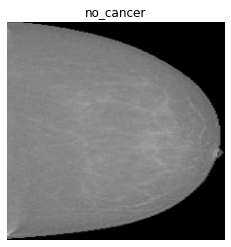

In [18]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
print(image.shape, label)

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [19]:
patch_size =16

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()

patchify = PatchEmbedding(in_channels=3,patch_size=16,embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image= patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [20]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.4984,  0.1177, -0.1638,  ...,  0.3439, -0.2024,  0.2115],
         [-0.5008,  0.0881, -0.1554,  ...,  0.3615, -0.1419,  0.1496],
         [-0.5248,  0.0477, -0.1927,  ...,  0.2379, -0.0234,  0.1112],
         ...,
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [21]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable


# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")
#patch_and_position_embedding

print(patch_embedding_class_token)  #1 is added in the beginning of each

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.4984,  0.1177, -0.1638,  ...,  0.3439, -0.2024,  0.2115],
         [-0.5008,  0.0881, -0.1554,  ...,  0.3615, -0.1419,  0.1496],
         ...,
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033],
         [-0.0188, -0.0114, -0.0311,  ...,  0.0105, -0.0033,  0.0033]]],
       grad_fn=<CatBackward0>)


In [22]:

class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """

    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12,
                 attn_dropout:float=0): 
        super().__init__()

     
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)


        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 

   
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, 
                                             key=x, 
                                             value=x, 
                                             need_weights=False) 
        return attn_output

In [23]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    def __init__(self,
                 embedding_dim:int=768, 
                 mlp_size:int=3072,
                 dropout:float=0.1): 
        super().__init__()

   
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)


        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), 
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, 
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout) 
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [24]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int=768,
                 num_heads:int=12, 
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0): 
        super().__init__()


        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)


        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):

        x =  self.msa_block(x) + x

        x = self.mlp_block(x) + x

        return x


In [25]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [26]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0,
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=1000): 
        super().__init__() 


        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

   
        self.num_patches = (img_size * img_size) // patch_size**2

  
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)


        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

    
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)


        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)


        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])


        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )


    def forward(self, x):


        batch_size = x.shape[0]


        class_token = self.class_embedding.expand(batch_size, -1, -1) 

  
        x = self.patch_embedding(x)

 
        x = torch.cat((class_token, x), dim=1)

   
        x = self.position_embedding + x


        x = self.embedding_dropout(x)


        x = self.transformer_encoder(x)

        x = self.classifier(x[:, 0])

        return x

In [30]:
model = ViT(num_classes=len(class_names))

In [28]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, 
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

In [32]:
criterion = torch.nn.CrossEntropyLoss()

In [1]:
from sklearn.metrics import accuracy_score

In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training and Testing Loop
for epoch in range(5):
    # Training
    model.train()
    train_loss = 0.0
    train_preds, train_targets = [], []
    for batch in train_dataloader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_targets.extend(targets.cpu().numpy())
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(accuracy_score(train_targets, train_preds))

    # Testing
    model.eval()
    test_loss = 0.0
    test_preds, test_targets = [], []
    with torch.no_grad():
        for batch in test_dataloader:
            inputs, targets = batch
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            test_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            test_targets.extend(targets.cpu().numpy())
    test_losses.append(test_loss / len(test_dataloader))
    test_accuracies.append(accuracy_score(test_targets, test_preds))

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_accuracies[-1]:.2f}, Test Loss: {test_losses[-1]:.3f}, Test Acc: {test_accuracies[-1]:.2f}")

# Plotting
fig, axs = plt.subplots(2, 1)
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_title('Loss vs Epochs')
axs[0].legend()

axs[1].plot(train_accuracies, label='Train Accuracy')
axs[1].plot(test_accuracies, label='Test Accuracy')
axs[1].set_title('Accuracy vs Epochs')
axs[1].legend()

plt.tight_layout()
plt.show()
